# Food101 image classification

Import all the libaries

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os

from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

Set up all the configurations

In [5]:
path = 'C:/Users/zdj07/Documents/private/study/cs231n/assignment/others/food101/'
classes_file = path + 'food-101/meta/classes.txt'
img_train_file = path + 'food-101/meta/train.txt'
img_test_file = path + 'food-101/meta/test.txt'
weight_path = path + 'saved_models/weights.epoch-01-val_loss-7.73.hdf5'
restore = 1
batch_size = 32
dropout = 0.5
epochs = 40
shape = (224, 224, 3)
mode = 'train'

Load and preprocess the dataset.
First, get information about the data. I load the label information.

In [6]:
def get_classes(file_path):
    with open(file_path) as f:
        classes = [l.strip() for l in f.readlines()]
    return classes
labels = get_classes(classes_file)
n_classes = len(labels)
class_to_ix = dict(zip(labels, range(n_classes)))
print('Total number of classes is',n_classes)

Total number of classes is 101


I load the images information.

In [7]:
def generate_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as f:
        files = [l.strip() for l in f.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

def load_an_image(img_path, dimentions=(256,256)):
    img = image.load_img(img_path,target_size=dimentions)
    x = image.img_to_array(img)
    #x = preprocess_input(x)
    return x

def load_images(files,dimentions = shape,sample = 2):
    all_imgs,all_classes = [],[]
    for label, pics in files.items():
        for i in range(sample):
            filename = path + 'food-101/images/%s/%s'% (label,pics[i])
            x = load_an_image(filename,dimentions)
            all_imgs.append(x)
            all_classes.append(class_to_ix[label])
    return np.array(all_imgs), np.array(all_classes)

I want to compare the work with the paper, so I use the same training and testing split. Below is a quick check for the training data file.

In [20]:
train_dir_files = generate_dir_file_map(img_train_file)
print('Training files: The 1st image in the category %s is:'%(labels[0]))
print(train_dir_files[labels[0]][0])

Training files: The 1st image in the category apple_pie is:
1005649.jpg


Plot it for visualization

C:/Users/zdj07/Documents/private/study/cs231n/assignment/others/food101/food-101/images/apple_pie/1005649.jpg


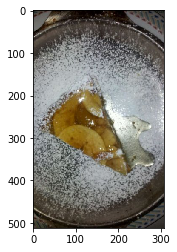

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline
label,pic = labels[0],train_dir_files[labels[0]][0]
filename = path + 'food-101/images/%s/%s'% (label,pic)
print(filename)
img = plt.imread(filename)
plt.imshow(img)

For each class, I sample 1 image to preview and print the image size. The image is of size: 224 * 224 * 3. Since there are 101 classes, the total number is 101 images.

In [24]:
xtrain,ytrain = load_images(train_dir_files,shape[:2],sample = 1)
print("The images shape is: ", xtrain.shape)

The images shape is:  (101, 224, 224, 3)


Considering the work of load data, I save all the data in the data.npz file for the first time. And next time I want to run it, I just load from the saved file directly. For the training data, it will be further split to training and evaluation set.

In [ ]:
if restore:
    data = np.load(path+'data.npz')
    xtrain,ytrain = data['xtrain'],data['ytrain']
    xtest,ytest = data['xtest'],data['ytest']
else:
    train_dir_files = generate_dir_file_map(img_train_file)
    test_dir_files = generate_dir_file_map(img_test_file)
    xtrain,ytrain = load_images(train_dir_files,shape[:2],sample = 750)
    xtest, ytest = load_images(test_dir_files,shape[:2],sample = 250)
    np.savez(path+'data', xtrain=xtrain,ytrain=ytrain,xtest=xtest,ytest=ytest)

According to the training data, write a function to generate data of batch size including images and labels.Also the images are preprocessed.

In [3]:
def setup_generator(xtrain, y_train_cat,xtest, y_val_cat):
    datagen = image.ImageDataGenerator(
         featurewise_center=False,  # set input mean to 0 over the dataset
         samplewise_center=False,  # set each sample mean to 0
         featurewise_std_normalization=False,  # divide inputs by std of the dataset
         samplewise_std_normalization=False,  # divide each input by its std
         zca_whitening=False,  # apply ZCA whitening
         rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
         width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
         height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
         horizontal_flip=True,  # randomly flip images
         rescale=1./255,
         fill_mode='nearest')
    
    datagen.fit(xtrain)
    train_generator = datagen.flow(xtrain, y_train_cat, batch_size=32)
    val_generator = datagen.flow(xtest, y_val_cat, batch_size=32)

    return train_generator, val_generator

Build the ResNet model.

In [2]:
def create_model(num_classes, dropout, shape):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=shape))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    return model

Train and Test:
I trained the model first and saved the weights in the folder "saved_models".Then run the test model.

In [ ]:
def train_model(model_final, train_generator, val_generator, callbacks):
    model_final.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

    model_final.fit_generator(train_generator, validation_data=val_generator,
                              epochs=epochs, callbacks=callbacks,
                              steps_per_epoch=xtrain.shape[0]//batch_size,
                              validation_steps=xval.shape[0]//batch_size)
    for layer in model_final.layers[:172]:
        layer.trainable = False
    for layer in model_final.layers[172:]:
        layer.trainable = True

save the trained weight and write a helper function to randomly sample a data point in the test set.

In [1]:
def load_weights(model_final, weights_path, shape):
    model_final = create_model(n_classes, 0, shape)
    model_final.load_weights(weights_path)
    return model_final

def get_sample_image():
    idx = np.random.choice(xtest.shape[0])
    x = np.expand_dims(xtest[idx],axis = 0)
    return x

Finally run the main procedures with all the help functions above.

In [ ]:
if mode == 'train' or not os.listdir(path + 'saved_models/'):
    
    xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=.20)
    y_train_cat = to_categorical(ytrain, num_classes=n_classes)
    y_val_cat = to_categorical(yval, num_classes=n_classes)
    train_generator,val_generator = setup_generator(xtrain, y_train_cat,xval, y_val_cat)
    
    callbacks = []
    callbacks.append(ModelCheckpoint(filepath=path+'saved_models/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
                                       verbose=1, save_best_only=True))
    
    model_final = create_model(n_classes,dropout, shape)

    train_model(model_final, train_generator, val_generator, callbacks)
else:
    trained_model = load_weights(model_final, weight_path, shape)
    img = get_sample_image()
    preds = trained_model.predict(img)
    print("the image is: ", labels[np.argmax(preds)])